# Flare vetting

In [1]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models.widgets import Button
from bokeh.layouts import row, column
from bokeh.plotting import figure, output_file, show

from altaipony.lcio import from_path

import pandas as pd
import numpy as np

output_notebook()


Loading BokehJS ...

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Choose the cluster

In [2]:
cluster = 'ngc2168'

In [3]:
df = pd.read_csv("../ClusterAnalysis/flares/{}_flares.csv".format(cluster))

In [4]:
df = df.dropna(subset=["ampl_rec", "ed_rec"])
df = df.drop_duplicates()
IDS = df.EPIC.unique()
IDS.shape

(1,)

## Select ID for LC with flares

In [5]:
ID = IDS[0]
Cs = df.Campaign[df.EPIC == ID].unique()
Cs

array([0.])

## Choose campaign with which to start

In [6]:
c = int(Cs[0])
ID

202059653

## Load light curve to inspect

In [7]:
try:
    flc = from_path("../DetrendedLightCurves/pony_k2sc_k2_llc_{}-c{:02d}_kepler_v2_lc.fits".format(ID, c), mode="AltaiPony", mission="K2")
except:
    flc = from_path("../DetrendedLightCurves/HAT_{}.fits".format(ID), mode="AltaiPony", mission="K2")
flc = flc[np.where(flc.time!=0.)]

/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='../DetrendedLightCurves/pony_k2sc_k2_llc_202059653-c00_kepler_v2_lc.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


## Load stellar parameters for a cross-check

In [8]:
params = pd.read_csv("../CDS/stars.csv", names=["ID","C", "RA", "Dec",
                                                "pmem", "outlier", "Teff",
                                                "eTeff", "R", "eR", "LumKepler",
                                                "eLumKepler"])
params[params.ID == ID]

,ID,C,RA,Dec,pmem,outlier,Teff,eTeff,R,eR,LumKepler,eLumKepler
1060,202059653,0,92.51708,23.98517,0.84,-999,4591,197,0.71,0.05,4.548464e+31,6.986072e+30


## Look at the light curve: Weird or not?

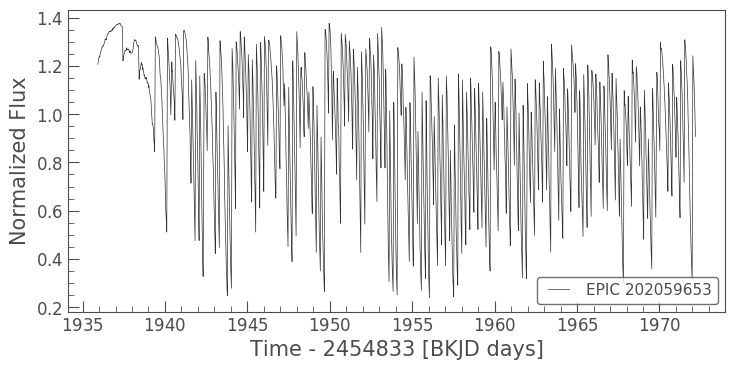

In [9]:
flc.plot()

## Create inspection suite and select true flares

In [15]:
dff = df[(df.EPIC == ID) & (df.Campaign == c)]
g = lambda x: flc.detrended_flux[np.where(x.tstart==flc.time)[0]+1][0]
dff["peak"] = dff.apply(g, axis=1)
dff["desc"] = dff.apply(lambda x: " {}, {}, {};".format(x.cstart, x.EPIC, x.Campaign), axis=1)

#---------------------------------------------------------------------------------------------------

LC = pd.DataFrame({"time":flc.time, "flux":flc.detrended_flux})
LC = LC.set_index("time")

#---------------------------------------------------------------------------------------------------

source = ColumnDataSource(LC)
flares = ColumnDataSource(data=dict(tstart=dff.tstart.values,
                                    peak=dff.peak.values,
                                    desc=dff.desc))



p = figure(plot_height=350, plot_width=900, title="ID {}, Campaign {}".format(ID, c),
           toolbar_location="right",
           #tools= "pan,wheel_zoom,box_zoom,reset, hover",
            tools="lasso_select", #title="Select Here",
           x_range=(np.min(LC.index.values), np.max(LC.index.values)))

for i, row in dff.iterrows():
    
    LCsub = LC.iloc[int(row.istart)-1: int(row.istop)+1,:]
    LCsub["upper"] = np.max(LCsub.index.values)
    LCsub["lower"] = np.min(LCsub.index.values)
    subset = ColumnDataSource(LCsub)
    p2 = BoxAnnotation(left=np.min(LCsub.index.values), 
                       right=np.max(LCsub.index.values), 
                       fill_alpha=0.5, fill_color='red')

    p.renderers.extend([p2])

p.line('time', 'flux', source=source,line_color="black")
p.xgrid.visible = False
p.ygrid.visible = False
p.circle('tstart', 'peak', source=flares, size=20, alpha=0.6)

#-------------------------------------------------------------------------------

s2 = ColumnDataSource(data=dict(tstart=[], peak=[]))
p2 = figure(plot_width=900, plot_height=300,
            tools="reset,wheel_zoom,box_zoom", title="Watch Here")
p2.circle('tstart', 'peak', source=s2, size=20, alpha=0.6)
p2.line('time', 'flux', source=source,line_color="black")

flares.selected.js_on_change('indices', CustomJS(args=dict(flares=flares, s2=s2,),code="""
        var inds = cb_obj.indices;
        var d1 = flares.data;
        var d2 = s2.data;
        d2['tstart'] = []
        d2['peak'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['tstart'].push(d1['tstart'][inds[i]])
            d2['peak'].push(d1['peak'][inds[i]])
        }
        s2.change.emit();
    """)
)

#--------------------------------------------------------------------------
savebutton = Button(label="Save", button_type="success")
savebutton.callback = CustomJS(args=dict(source_data=flares), code="""
            var inds = source_data.selected['1d'].indices;
            var data = source_data.data;
            var out = "";
            for (i = 0; i < inds.length; i++) {
                out += data['desc'][inds[i]] + " ";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'vetted.txt';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """)

#-------------------------------------------------------------------
layout = column(p, p2, savebutton)
show(layout)


/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
